## **FUNCTIONS, VARS, INIT**

#### Welcome to plaso evtx notebook!
First of all, let's create a couple of variables we will use later: home_path (home path of the created environment) and thisnb (name of the current notebook).

In [4]:
home_path=!pwd
thisnb=home_path[0]+"/plaso_evtx.ipynb"

## **IMPORTS & INIT**

For making the notebook work, we load all the needed libraries and imports, including ds4n6_lib, that are defined in the imports.ipynb notebook. Besides, we will unactivate the warnings in order to have a clean result. This is the same cell for all the notebooks in the project. 

In [5]:
%run imports.ipynb
warnings.filterwarnings("ignore")

## **READ DATA**

We download the outputs we got running plaso in the evidence. We do it via gdown (Google Drive) functions, downloading and extracting the plaso.json file. If you have your own plaso outputs in json, you can change the URL ID and download the yours. In this case, we only have Windows Events in the json.

In [6]:
url = 'https://drive.google.com/uc?id=1BLyjlCy5tPMyPBgEiPWFkcZEenzIUwiC'
of = 'plaso_evtx.tgz'
gdown.download(url, of, quiet=False)
gdown.extractall("plaso_evtx.tgz", to="./")

Downloading...
From: https://drive.google.com/uc?id=1BLyjlCy5tPMyPBgEiPWFkcZEenzIUwiC
To: /home/jovyan/plaso_evtx.tgz
100%|██████████| 639k/639k [00:00<00:00, 76.1MB/s]


['./plaso.json']

Once data has been correctly downloaded, let's read it with the xread() function, which comes from ds4n6_lib and it allows us to read the data from different tools, creating an harmonized pickle with all the information (you will notice plaso.json.pkl is in you home). This .pkl file is the one used to read the data in a very fast way from now.

In [7]:
xread(tool="plaso", notebook_file=thisnb)

- Searching notebook for saved input file / folder (_plasod)
  + Found: /home/jovyan/plaso.json

- Reading file(s):
- No saved Harmonized pickle file found.

    /home/jovyan/plaso.json
- Reading json file lines: [0] 

- Generating pandas dataframes: 
  + windows_evtx_record                           ...  [9792]
- Harmonizing pandas dataframes: 
  + windows_evtx_record                           ...  [OK]
- Done Harmonizing.


NOTE: Now you can use the syntax <yourvar>['<datatype>'] to access your specific dataframe

- Reading Done.

- Recover the object read by executing:  myvar = d4.out (e.g. mydf = d4.out)



Once that the xread() function has done its magic, let's save the result in "pldfs" (Plaso dataframes). This variable may contain many dataframes, one per parsed artifact. As for this notebook we are only loading Windows Events, we will only have one dataframe.

In [8]:
pldfs = d4.out

In [9]:
# Automatically created - DO NOT EDIT OR REMOVE unless you want to change the file to read (in that case, remove this cell)
# 2021-04-08 10:44:44.843675
# _plasod_f2read = "/home/jovyan/plaso.json"

## **ANALYSIS**

### **DEFINITIONS AND VARS**

Now let's define how we want our dataframes to look like. With xdisplay() function you can shape them to your liking.

In [10]:
xdisplay()

#### Pandas options

IntText(value=60, description='display.max_rows: ', style=DescriptionStyle(description_width='initial'))

IntText(value=10, description='display.min_rows: ', style=DescriptionStyle(description_width='initial'))

IntText(value=20, description='display.max_columns: ', style=DescriptionStyle(description_width='initial'))

Dropdown(description='display.colheader_justify: ', options=('right', 'left'), style=DescriptionStyle(descript…

Checkbox(value=True, description='display.expand_frame_repr', indent=False, style=DescriptionStyle(description…

In pldfs we have a dataframe per parsed artifact. In this case we only have Windows Events, so there is only one dataframe but with the information of all the different Windows Events files. With the next cell we will get one dataframe for every different events file. All these dataframes will be in the evtxrawdf variable

In [66]:
evtxrawdfs = d4pl.plaso_get_evtxdfs(pldfs, datapath="./", notebook_file=thisnb, hostname='host', evtxdfs_usepickle=False)

Extracting evtx DFs dict from plaso DFs dict.
- Looking for notebook cell containing pickle file to read (host_evtxdfspklf)
  + Not found
- Looking for evtxdfs pickle file in datapath directory:
  + Not found.
- Extracting records...
- Processing:
  + Microsoft-Windows-RemoteDesktopServices-RdpCoreTS%4Operational.evtx
    - Extracting & concatenating plaso xml_string entries
    - Escaping/fixing not well-formed records
    - Converting XML -> DF

  + Security.evtx
    - Extracting & concatenating plaso xml_string entries
    - Escaping/fixing not well-formed records
    - Converting XML -> DF

  + Microsoft-Windows-TerminalServices-RemoteConnectionManager%4Operational.evtx
    - Extracting & concatenating plaso xml_string entries
    - Escaping/fixing not well-formed records
    - Converting XML -> DF

  + Microsoft-Windows-Kernel-PnPConfig%4Configuration.evtx
    - Extracting & concatenating plaso xml_string entries
    - Escaping/fixing not well-formed records
      + Rule executed:

In the next cell we are going to extract one of the Windows Events files (Security.evtx) to a dataframe. If you want to know all the dataframes available in the evtxrawdfs variable, you can run evtxrawdfs.keys() and perform the analysis of another file. In order to make everything much more simple, we are going to normalize the columns with the consolidate_columns_func() function, deleting not necessary columns, renaming for a user friendly experience, etc.

In [67]:
secevtxrawdf = evtxrawdfs['Security.evtx']
secevtxdf = d4evtx.consolidate_columns_func(secevtxrawdf)

Parsing evtids: [Security.evtx] 4624 4625 4634 4647 4648 4662 4672 4768 4769 4776 

We already have a dataframe for each Windows Event file, but what if we want to analyze the events of a specific Event ID? With the next cell, we will get one dataframe for every event ID in the Security.evtx file. We could know all the generated dataframes by running secevtxidrawdfs.keys()

In [69]:
secevtxidrawdfs = d4evtx.evtid_dfs_build_raw(secevtxrawdf)

For the further users access analysis we will perform, we need all the 4624 events, so let's get a dataframe with this information in evtx4624df

In [70]:
evts4624rawdf = secevtxidrawdfs[4624]
evtx4624df = d4evtx.consolidate_columns_func(evts4624rawdf)

### **GENERIC**

Finally, let's move to the fun part: The analysis! Let's start with a generic analysis and a couple of interesting functions for all the dataframes: value_counts() to get statistics about a specific column of a dataframe and xgrep, to perform a search in a dataframe

For the generic dataframe analysis, we will use ag-grid, one of the integrated plugins we have to show the dataframes. With this plugin, and in a very easy way, you can filter, delete or perform different actions in the columns. Let's display the evtx4624 dataframe

In [33]:
d4gui.aggrid(secevtxdf)

Grid(columns_fit='auto', compress_data=True, export_mode='auto', height='350px', menu={'buttons': [{'name': 'E…

In [72]:
secevtxrawdf['EventID_'].value_counts()

4624    716
4634    704
4672    680
4625    162
4769     28
4648     22
4768     14
4776      8
4647      6
4662      4
Name: EventID_, dtype: int64

To search for a concrete string, you can use xgrep() function. All the hard work will be done for you!

In [45]:
searchstring="Administrator"
xgrep(secevtxdf, searchstring)

,Timestamp,EventRecordID,EventID_,D4_DataType_,D4_Tool_,D4_Plugin_,D4_Hostname_,evtxFileName_,ProviderName,ProviderGuid,Version,Level,Task,Opcode,Keywords,ProcessID,ThreadID,Channel,Computer,PackageName,TargetUserName,Workstation,Status,TargetDomainName,ServiceName,ServiceSid,TicketOptions,TicketEncryptionType,IpPort,LogonGuid,TransmittedServices,IpAddress,TargetSid,PreAuthType,SubjectUserSid,SubjectUserName,SubjectDomainName,SubjectLogonId,PrivilegeList,ObjectServer,ObjectType,OperationType,HandleId,AccessList,AccessMask,Properties,AdditionalInfo,ObjectName,TargetLogonGuid,TargetServerName,TargetInfo,ProcessId,ProcessName,TargetUserSid,TargetLogonId,LogonType,FailureReason,SubStatus,LogonProcessName,AuthenticationPackageName,WorkstationName,LmPackageName,KeyLength,ImpersonationLevel
0,2020-09-19 03:21:29,7403,4625,evtx-raw,plaso,windows_evtx_record,,Security.evtx,Microsoft-Windows-Security-Auditing,{54849625-5478-4994-A5BA-3E3B0328C30D},0,0,12544,0,0x8010000000000000,460,1016,Security,CITADEL-DC01.C137.local,nan,Administrator,nan,0xc000006d,nan,nan,nan,nan,nan,-,nan,-,-,nan,nan,S-1-0-0,-,-,0x0000000000000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0x0000000000000000,-,S-1-0-0,nan,3,%%2313,0xc000006a,NtLmSsp,NTLM,kali,-,0,nan
1,2020-09-19 03:21:29,7404,4625,evtx-raw,plaso,windows_evtx_record,,Security.evtx,Microsoft-Windows-Security-Auditing,{54849625-5478-4994-A5BA-3E3B0328C30D},0,0,12544,0,0x8010000000000000,460,1016,Security,CITADEL-DC01.C137.local,nan,Administrator,nan,0xc000006d,nan,nan,nan,nan,nan,-,nan,-,-,nan,nan,S-1-0-0,-,-,0x0000000000000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0x0000000000000000,-,S-1-0-0,nan,3,%%2313,0xc000006a,NtLmSsp,NTLM,kali,-,0,nan
2,2020-09-19 03:21:29,7405,4625,evtx-raw,plaso,windows_evtx_record,,Security.evtx,Microsoft-Windows-Security-Auditing,{54849625-5478-4994-A5BA-3E3B0328C30D},0,0,12544,0,0x8010000000000000,460,1016,Security,CITADEL-DC01.C137.local,nan,Administrator,nan,0xc000006d,nan,nan,nan,nan,nan,-,nan,-,-,nan,nan,S-1-0-0,-,-,0x0000000000000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0x0000000000000000,-,S-1-0-0,nan,3,%%2313,0xc000006a,NtLmSsp,NTLM,kali,-,0,nan
3,2020-09-19 03:21:29,7406,4625,evtx-raw,plaso,windows_evtx_record,,Security.evtx,Microsoft-Windows-Security-Auditing,{54849625-5478-4994-A5BA-3E3B0328C30D},0,0,12544,0,0x8010000000000000,460,1016,Security,CITADEL-DC01.C137.local,nan,Administrator,nan,0xc000006d,nan,nan,nan,nan,nan,-,nan,-,-,nan,nan,S-1-0-0,-,-,0x0000000000000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0x0000000000000000,-,S-1-0-0,nan,3,%%2313,0xc000006a,NtLmSsp,NTLM,kali,-,0,nan
4,2020-09-19 03:21:30,7407,4625,evtx-raw,plaso,windows_evtx_record,,Security.evtx,Microsoft-Windows-Security-Auditing,{54849625-5478-4994-A5BA-3E3B0328C30D},0,0,12544,0,0x8010000000000000,460,2968,Security,CITADEL-DC01.C137.local,nan,Administrator,nan,0xc000006d,nan,nan,nan,nan,nan,-,nan,-,-,nan,nan,S-1-0-0,-,-,0x0000000000000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0x0000000000000000,-,S-1-0-0,nan,3,%%2313,0xc000006a,NtLmSsp,NTLM,kali,-,0,nan
5,2020-09-19 03:21:30,7408,4625,evtx-raw,plaso,windows_evtx_record,,Security.evtx,Microsoft-Windows-Security-Auditing,{54849625-5478-4994-A5BA-3E3B0328C30D},0,0,12544,0,0x8010000000000000,460,2968,Security,CITADEL-DC01.C137.local,nan,Administrator,nan,0xc000006d,nan,nan,nan,nan,nan,-,nan,-,-,nan,nan,S-1-0-0,-,-,0x0000000000000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0x0000000000000000,-,S-1-0-0,nan,3,%%2313,0xc000006a,NtLmSsp,NTLM,kali,-,0,nan
6,2020-09-19 03:21:30,7409,4625,evtx-raw,plaso,windows_evtx_record,,Security.evtx,Microsoft-Windows-Security-Auditing,{54849625-5478-4994-A5BA-3E3B0328C30D},0,0,12544,0,0x8010000000000000,460,2968,Security,CITADEL-DC01.C137.local,nan,Administrator,nan,0xc000006d,nan,nan,nan,nan,nan,-,nan,-,-,nan,nan,S-1-0-0,-,-,0x0000000000000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0x0000000000000000,-,S-1-0-0,nan,3,%%2313,0

### **EVENTS SPECIFIC**

Now let's see how we can made stats easy!

In [16]:
#PENDIENTE DE REVISIÓN

#d4evtx.evtid_stats(secevtxrawdf)
#d4evtx.analysis_evtids_stats(secevtxrawdf)

Finally, with analysis_access() and analysis_access_graph() functions you can ...........................

,WorkstationName,Count
0,CITADEL-DC01,5
1,kali,4
,IpAddress,Count
0,10.42.85.115,40
1,-,5
2,194.61.24.102,4
3,127.0.0.1,1
,Timestamp,TargetUserName
0,2020-09-19 03:21:47,Administrator
1,2020-09-19 03:28:21,DESKTOP-SDN1RPT$


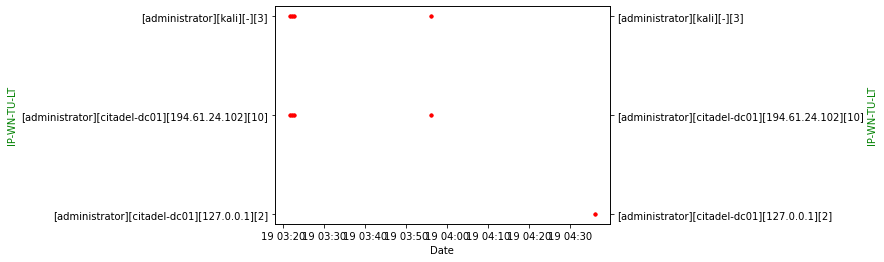

,Timestamp,WorkstationName,IpAddress,TargetUserName,LogonType,Count
0,2020-09-19,citadel-dc01,127.0.0.1,Administrator,2,1
1,2020-09-19,citadel-dc01,194.61.24.102,Administrator,10,4
2,2020-09-19,kali,-,Administrator,3,4


In [18]:
d4evtx.analysis_access(evtx4624df)

In [19]:
d4evtx.analysis_access_stats(evtx4624df)

,WorkstationName,Count
0,CITADEL-DC01,5
1,kali,4
,IpAddress,Count
0,10.42.85.115,40
1,-,5
2,194.61.24.102,4
3,127.0.0.1,1
,Timestamp,TargetUserName
0,2020-09-19 03:21:47,Administrator
1,2020-09-19 03:28:21,DESKTOP-SDN1RPT$


,Timestamp,WorkstationName,IpAddress,TargetUserName,LogonType,Count
0,2020-09-19,citadel-dc01,127.0.0.1,Administrator,2,1
1,2020-09-19,citadel-dc01,194.61.24.102,Administrator,10,4
2,2020-09-19,kali,-,Administrator,3,4


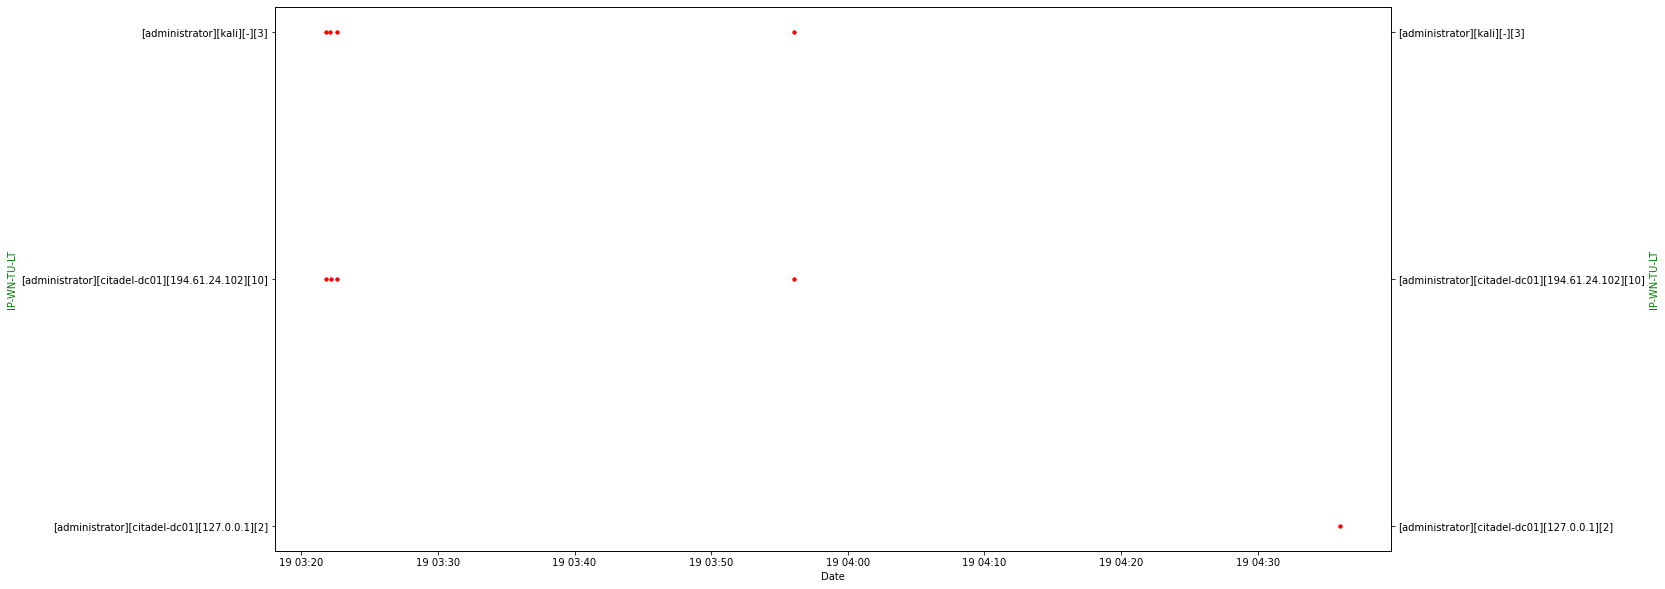

In [20]:
d4evtx.analysis_access_graph(evtx4624df)